In [1]:
# Source: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [2]:
#autoreload
%load_ext autoreload
%autoreload 2


In [3]:

try:
  import google.colab
  IN_COLAB = True
  

  from google.colab import drive
  drive.mount('/content/gdrive')
except:
  IN_COLAB = False

In [4]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings
import torch
if IN_COLAB:
    folder = "/content/gdrive/MyDrive/MILA_BOYS_FINAL/Final_Deliverable" #@param {type:"string"}
    !ln -Ts $folder /content/Final_Deliverable 2> /dev/null

    # Add the assignment folder to Python path
    if '/content/Final_Deliverable' not in sys.path:
        sys.path.insert(0, '/content/Final_Deliverable')

    # Install requirements
    !pip install -qr /content/Final_Deliverable/requirements.txt
else:
    sys.path.insert(0, '../')

# Check if CUDA is available
if not torch.cuda.is_available():
    warnings.warn('CUDA is not available.')


C:\Users\saiak\AppData\Local\Temp\ipykernel_21580\3720997126.py:26: UserWarning: CUDA is not available.
  warnings.warn('CUDA is not available.')


In [5]:
import torch
import numpy as np
import sys

import segmentation_models_pytorch as smp
#from Models.SpadeUnet.model import SpadeUnet,SpadeSMPUnet
from Models.SpadeUnet.VanillaUnet import VanillaUnet
# from Models.SpadeUnet.spade_resize import SpadeResNetEncoder,UResNetEncoder
# from Models.SpadeUnet.SpadeBlock import SPADEResnetBlock

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import train 
import random
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

In [6]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [7]:
if IN_COLAB:
    ROOT_DIR = 'Final_Deliverable'
    DATA_DIR = "Final_Deliverable/Data/process_data"
else:
    ROOT_DIR = '../'
    DATA_DIR = "../Data/process_data"

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'valid_masks')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_masks')

context_dir = os.path.join(DATA_DIR, 'context')


IMG_SIZE = (128, 128)
BATCH_SIZE = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
experiment_name = "VanillaUNETNewData"

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
class Dataset(BaseDataset):
    """Read images, apply preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        context_dir (str): path to contextual images folder
        classes (list): values of classes to extract from segmentation mask
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['non-tumor', 'tumor']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            context_dir,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [fname for fname in os.listdir(images_dir) if os.path.exists(os.path.join(context_dir,fname)) and fname != "desktop.ini"]
        

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.contexts_fps = [os.path.join(context_dir, image_id) for image_id in self.ids]
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        

        try: 
            
            # read data
            image = cv2.imread(self.images_fps[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.masks_fps[i], 0)
        except:
            raise Exception('fname {}'.format(self.contexts_fps[i]))
            
        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        

         # apply preprocessing
        if self.preprocessing:

            image, mask = self.preprocessing(image), self.preprocessing(mask)
            image = image / 255            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [10]:
import albumentations as albu
from PIL import Image


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(IMG_SIZE)])

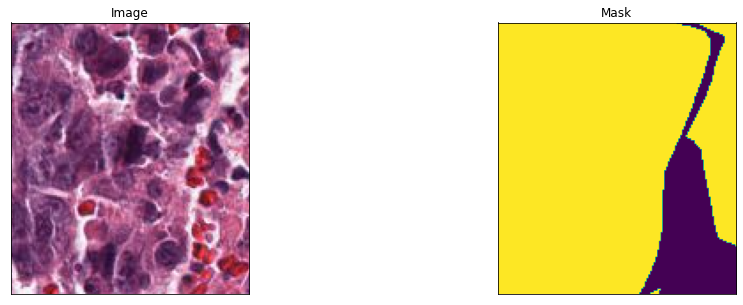

In [11]:
# # Lets look at data we have
# dataset = Dataset(x_train_dir, y_train_dir,context_dir, classes=['tumor'], preprocessing=transform)

# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir,context_dir, classes=['tumor'], preprocessing=None)


image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [12]:
# VanillaUnet
CLASSES = ['tumor']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

smp.encoders.encoders["VanillaUnet"] = {
    "encoder": VanillaUnet, # encoder class here
    "params": {},
}


model = smp.Unet(encoder_name='VanillaUnet',encoder_weights=None,encoder_depth=4, decoder_channels=(256, 128, 64, 32),activation=ACTIVATION,classes=len(CLASSES))


In [13]:
print(
        f"Initialized  model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

Initialized  model with 3322753 total parameters, of which 3322753 are learnable.


In [14]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [15]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
# from segmentation_models_pytorch_custom import utils

loss =   smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3,mode='max',verbose=True)

In [16]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch =  smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [18]:
# train model for 5 epochs
max_score = 0

train_dice_loss , valid_dice_loss = [], []
train_iou_score, valid_iou_score = [], []

log = {}

for i in range(0, 5):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_dice_loss.append(train_logs['dice_loss'])    
    valid_dice_loss.append(valid_logs['dice_loss'])
    
    train_iou_score.append(train_logs['iou_score'])    
    valid_iou_score.append(valid_logs['iou_score'])

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f"{ROOT_DIR}/Saved_Models/{experiment_name}.pth")
        print('Model saved!')
    scheduler.step(valid_logs['iou_score'])



Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s, dice_loss - 0.6159, iou_score - 0.2817, fscore - 0.3853]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s, dice_loss - 0.6164, iou_score - 0.2817, fscore - 0.3854]
Model saved!
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.

Epoch: 2
valid: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s, dice_loss - 0.6172, iou_score - 0.2817, fscore - 0.3854]

Epoch: 3
valid: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s, dice_loss - 0.6179, iou_score - 0.2815, fscore - 0.3853]

Epoch: 4
valid: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, dice_loss - 0.6174, iou_score - 0.2817, fscore - 0.3854]


In [19]:
log['train_dice_loss'] = train_dice_loss
log['valid_dice_loss'] = valid_dice_loss
log['train_iou_score'] = train_iou_score
log['valid_iou_score'] = valid_iou_score
log['optimizer'] = 'Adam'

In [20]:
log

{'train_dice_loss': [0.1685387395979129,
  0.2975248932886327,
  0.16993116593494825,
  0.1488421714642267,
  0.36700944264077606],
 'valid_dice_loss': [0.6158812289530361,
  0.6163903519455962,
  0.6171715191352242,
  0.6178625115098071,
  0.6174147543852296],
 'train_iou_score': [0.7828536690359365,
  0.5940356557612835,
  0.7711726855243074,
  0.8070797800054185,
  0.5961586587037224],
 'valid_iou_score': [0.28170734981656,
  0.28170971787475346,
  0.28168921015695786,
  0.2815363565998418,
  0.2817038667032153],
 'optimizer': 'Adam'}

In [21]:
# Save data log
import json
json_file =f"{ROOT_DIR}/Logs/{experiment_name}.json" 
with open(json_file, "w") as file:
	json.dump(log, file)

In [22]:
# load best saved checkpoint
best_model = torch.load(f"{ROOT_DIR}/Saved_Models/{experiment_name}.pth")

In [23]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    context_dir,
    preprocessing=transform,
    classes=CLASSES,
)




In [24]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=device,
)

In [25]:
test_dataloader = DataLoader(test_dataset,batch_size=8, shuffle=False, num_workers=0)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s, dice_loss - 0.698, iou_score - 0.2171, fscore - 0.3027] 


In [26]:
# Valid dataset without transformations for image visualization
valid_dataset_vis = Dataset(
    x_valid_dir, y_valid_dir, context_dir,
    classes=CLASSES,
)

Prediction mask visualization

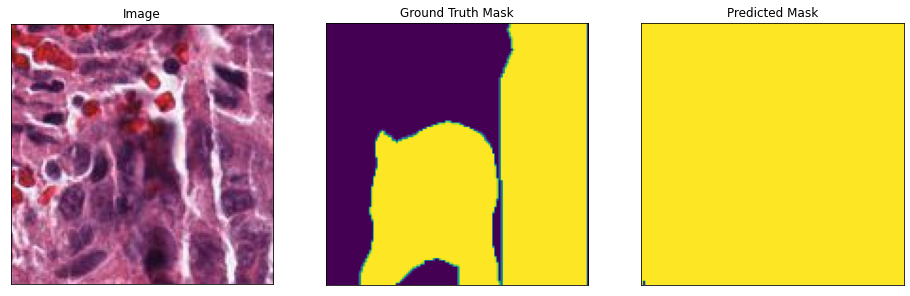

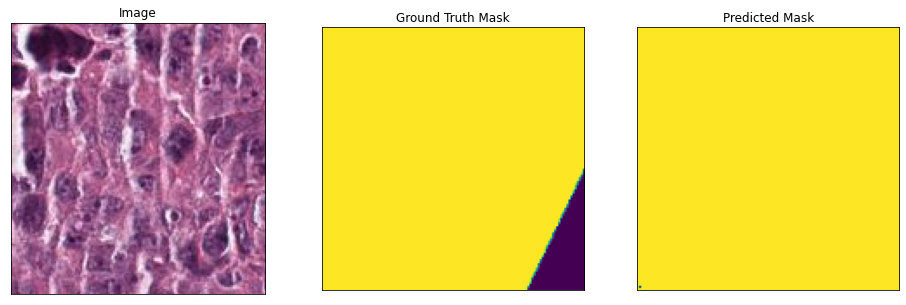

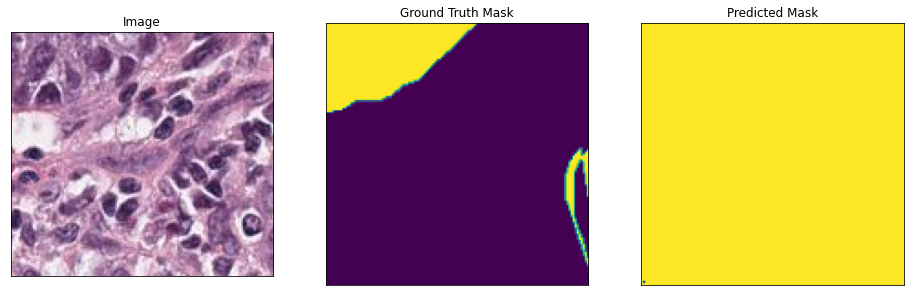

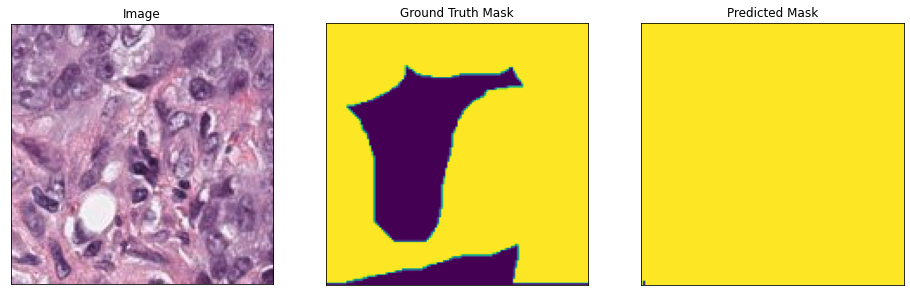

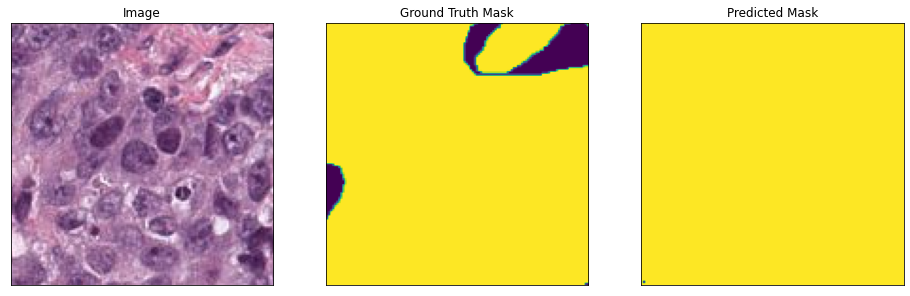

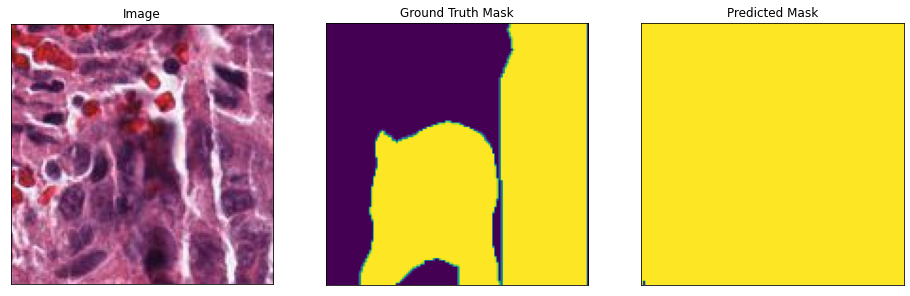

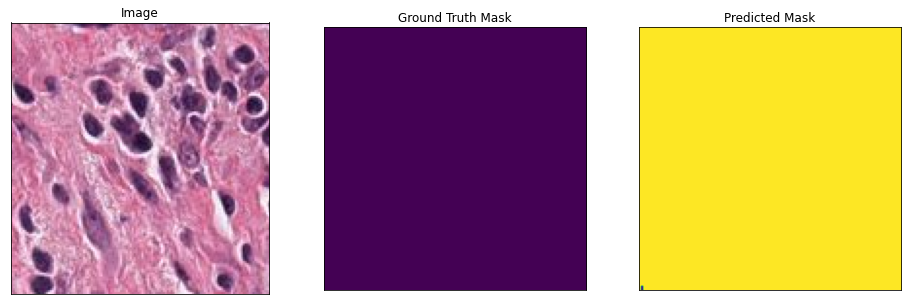

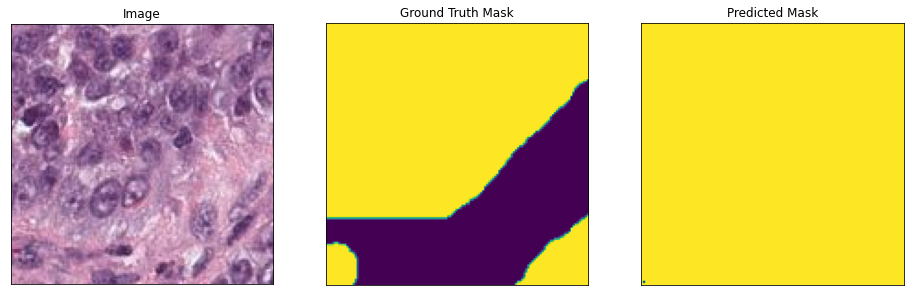

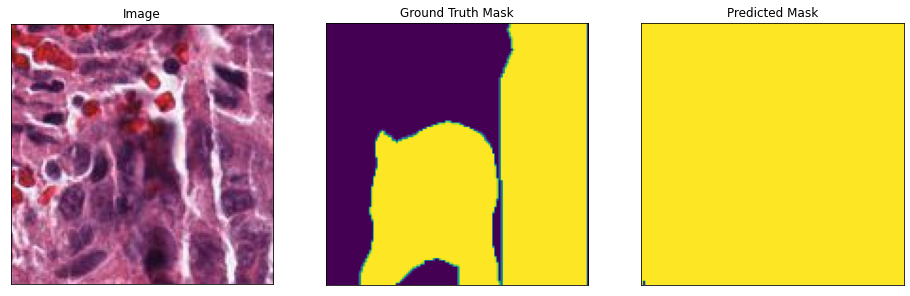

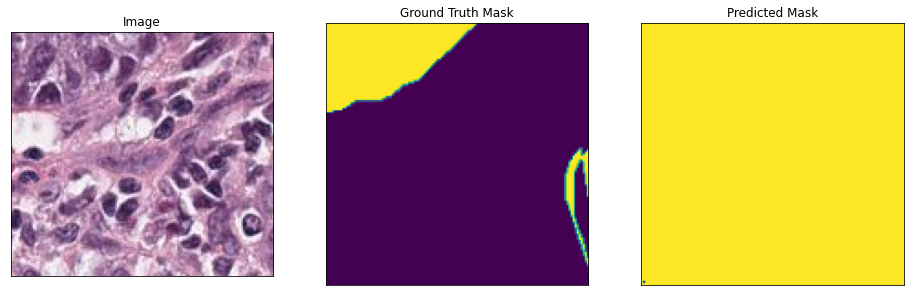

In [27]:
# Note : result is bad because this is a demo notebook and model is trained on only few images.
for i in range(10):
    n = np.random.choice(len(valid_dataset))
    image_vis = valid_dataset_vis[n][0].astype('uint8')
    image, gt_mask = valid_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = image.to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )